<a href="https://colab.research.google.com/github/bhavana217/Project/blob/master/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import pickle
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
datasets = {
    'hurricane' : pd.read_csv("/content/Hurricane.csv"),
    'bombings' : pd.read_csv("/content/bombings.csv"),
    'tornado': pd.read_csv("/content/tornado.csv"),
    'explosion' : pd.read_csv("/content/explosion.csv"),
    'flood': pd.read_csv("/content/floods.csv")
}

In [ ]:
for key in datasets.keys():
    df = datasets[key]
    df['id'] = df['tweet id']
    df['text'] = df[' tweet']
    df['label'] = df[' label']
    datasets[key] = df.drop(['tweet id', ' tweet', ' label'], axis=1)

In [ ]:
datasets['hurricane'].head()

,id,text,label
0,'262596552399396864',I've got enough candles to supply a Mexican fa...,off-topic
1,'263044104500420609',Sandy be soooo mad that she be shattering our ...,on-topic
2,'263309629973491712',@ibexgirl thankfully Hurricane Waugh played it...,off-topic
3,'263422851133079552',@taos you never got that magnificent case of B...,off-topic
4,'262404311223504896',"I'm at Mad River Bar &amp; Grille (New York, N...",off-topic


In [ ]:
datasets['bombings'].head()

,id,text,label
0,'325208201740029952',Funny how I got twenty minutes of sleep last n...,off-topic
1,'325301650791215106',I just wanna go outside,off-topic
2,'325182966332530688',This is fucking crazy. Suspect # 2 has like 2 ...,on-topic
3,'324654539850539009',"@J_Adams91 oops, someone doesn't like to be to...",off-topic
4,'323630018536275968',Let me love you @GavinQuin you know who else too,off-topic


In [ ]:
datasets['tornado'].head()

,id,text,label
0,'336908711324962817',@HeatleyJheat44 its barley even raining where ...,on-topic
1,'337052158035890176',Sorry I can't do anything right.,off-topic
2,'339338021751103488',@mrwendell29: @BradSowderWX says we have the ...,on-topic
3,'336339509077762051',#honestyhour I like to wear half split running...,off-topic
4,'337734129972035584',I'm too stressed to have a good summer,off-topic


In [ ]:
for key, df in datasets.items():
    vc = df['label'].value_counts()
    print("-"*50)
    print(f"{key}")
    print("-"*50)
    print(vc)

--------------------------------------------------
hurricane
--------------------------------------------------
on-topic     6138
off-topic    3870
Name: label, dtype: int64
--------------------------------------------------
bombings
--------------------------------------------------
on-topic     5648
off-topic    4364
Name: label, dtype: int64
--------------------------------------------------
tornado
--------------------------------------------------
off-topic    5165
on-topic     4827
Name: label, dtype: int64
--------------------------------------------------
explosion
--------------------------------------------------
on-topic     5246
off-topic    4760
Name: label, dtype: int64
--------------------------------------------------
flood
--------------------------------------------------
on-topic     5414
off-topic    4619
Name: label, dtype: int64


In [ ]:
for key in datasets.keys():
    df = datasets[key]
    df = df[df['label'].str.contains('on-topic')]
    datasets[key] = df

In [ ]:
for key, df in datasets.items():
    vc = df['label'].value_counts()
    print("-"*50)
    print(f"{key}")
    print("-"*50)
    print(vc)

--------------------------------------------------
hurricane
--------------------------------------------------
on-topic    6138
Name: label, dtype: int64
--------------------------------------------------
bombings
--------------------------------------------------
on-topic    5648
Name: label, dtype: int64
--------------------------------------------------
tornado
--------------------------------------------------
on-topic    4827
Name: label, dtype: int64
--------------------------------------------------
explosion
--------------------------------------------------
on-topic    5246
Name: label, dtype: int64
--------------------------------------------------
flood
--------------------------------------------------
on-topic    5414
Name: label, dtype: int64


In [ ]:
for key in datasets.keys():
    datasets[key]['crisis'] = key

In [ ]:
all_datasets = pd.concat(list(datasets.values()))

In [ ]:
all_datasets['id'] = all_datasets['id'].apply(lambda x: int(x.replace("'", "")))

In [ ]:
all_datasets

,id,text,label,crisis
1,263044104500420609,Sandy be soooo mad that she be shattering our ...,on-topic,hurricane
5,263101347421888513,Neighborly duties. @Cory_Kennedy arrives to th...,on-topic,hurricane
7,263298821189156865,I don't know how I'm getting back to Jersey si...,on-topic,hurricane
10,262914476989358080,Already flooded so much #SANDY @ Hoboken http:...,on-topic,hurricane
12,262991999911743490,"On that note, i pray that everyone stays safe,...",on-topic,hurricane
...,...,...,...,...
10028,295771687755063297,RT @aus_politics: Abbott raises spectre of new...,on-topic,flood
10029,295733360620363776,RT @bravotrav: Tony Abbott is visiting flood a...,on-topic,flood
10030,295464508074360832,RT @9NewsGoldCoast: Much of Queensland is toni...,on-topic,flood
10031,296225704784314368,.@GeodesignB #flood barrier now set up in #Au...,on-topic,flood


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from wordcloud import STOPWORDS
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
from nltk.stem.porter import *
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [ ]:
from tqdm import tqdm
cleantext=[]
for item in tqdm(all_datasets['text']):
    words=tweet_to_words(item)
    cleantext+=[words]
all_datasets['cleantext']=cleantext
all_datasets

100%|██████████| 27273/27273 [01:12<00:00, 374.38it/s]


,id,text,label,crisis,cleantext
1,263044104500420609,Sandy be soooo mad that she be shattering our ...,on-topic,hurricane,"[sandi, soooo, mad, shatter, door, shiet, hurr..."
5,263101347421888513,Neighborly duties. @Cory_Kennedy arrives to th...,on-topic,hurricane,"[neighborli, duti, cori, kennedi, arriv, rescu..."
7,263298821189156865,I don't know how I'm getting back to Jersey si...,on-topic,hurricane,"[know, get, back, jersey, sinc, train, subway,..."
10,262914476989358080,Already flooded so much #SANDY @ Hoboken http:...,on-topic,hurricane,"[alreadi, flood, much, sandi, hoboken, http, c..."
12,262991999911743490,"On that note, i pray that everyone stays safe,...",on-topic,hurricane,"[note, pray, everyon, stay, safe, keep, posit,..."
...,...,...,...,...,...
10028,295771687755063297,RT @aus_politics: Abbott raises spectre of new...,on-topic,flood,"[rt, au, polit, abbott, rais, spectr, new, flo..."
10029,295733360620363776,RT @bravotrav: Tony Abbott is visiting flood a...,on-topic,flood,"[rt, bravotrav, toni, abbott, visit, flood, af..."
10030,295464508074360832,RT @9NewsGoldCoast: Much of Queensland is toni...,on-topic,flood,"[rt, 9newsgoldcoast, much, queensland, tonight..."
10031,296225704784314368,.@GeodesignB #flood barrier now set up in #Au...,on-topic,flood,"[geodesignb, flood, barrier, set, australia, 1..."


In [ ]:
words = ' '.join(all_datasets['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=500,
                      background_color='white',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500
                     ).generate(cleaned_word)

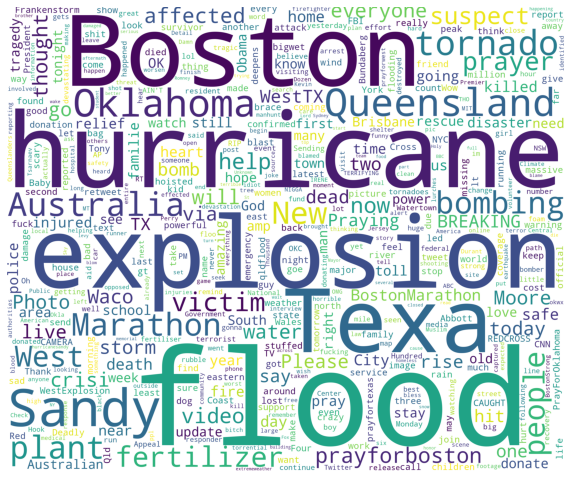

flood        1.000000
hurricane    0.907895
explosion    0.832583
Boston       0.829986
Texa         0.661704
dtype: float64

In [ ]:
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
wordcloud_words = wordcloud.words_
s  = pd.Series(wordcloud_words,index=wordcloud_words.keys())
s.head(5)

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df2 = compute_vader_scores(all_datasets,'cleantext')
# df2

In [ ]:
len(df2)

27273

In [ ]:
df2.reset_index(drop=True, inplace=True)
df2

,id,text,label,crisis,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,263044104500420609,Sandy be soooo mad that she be shattering our ...,on-topic,hurricane,"[sandi, soooo, mad, shatter, door, shiet, hurr...",0.348,0.652,0.000,-0.4939,sandi soooo mad shatter door shiet hurricanesa...
1,263101347421888513,Neighborly duties. @Cory_Kennedy arrives to th...,on-topic,hurricane,"[neighborli, duti, cori, kennedi, arriv, rescu...",0.000,1.000,0.000,0.0000,neighborli duti cori kennedi arriv rescu sport...
2,263298821189156865,I don't know how I'm getting back to Jersey si...,on-topic,hurricane,"[know, get, back, jersey, sinc, train, subway,...",0.000,1.000,0.000,0.0000,know get back jersey sinc train subway run
3,262914476989358080,Already flooded so much #SANDY @ Hoboken http:...,on-topic,hurricane,"[alreadi, flood, much, sandi, hoboken, http, c...",0.000,1.000,0.000,0.0000,alreadi flood much sandi hoboken http co mphft...
4,262991999911743490,"On that note, i pray that everyone stays safe,...",on-topic,hurricane,"[note, pray, everyon, stay, safe, keep, posit,...",0.000,0.574,0.426,0.6369,note pray everyon stay safe keep posit attitud...
...,...,...,...,...,...,...,...,...,...,...
27268,295771687755063297,RT @aus_politics: Abbott raises spectre of new...,on-topic,flood,"[rt, au, polit, abbott, rais, spectr, new, flo...",0.069,0.931,0.000,-0.1027,rt au polit abbott rais spectr new flood levi ...
27269,295733360620363776,RT @bravotrav: Tony Abbott is visiting flood a...,on-topic,flood,"[rt, bravotrav, toni, abbott, visit, flood, af...",0.000,0.859,0.141,0.3182,rt bravotrav toni abbott visit flood affect ar...
27270,295464508074360832,RT @9NewsGoldCoast: Much of Queensland is toni...,on-topic,flood,"[rt, 9newsgoldcoast, much, queensland, tonight...",0.000,1.000,0.000,0.0000,rt 9newsgoldcoast much queensland tonight face...
27271,296225704784314368,.@GeodesignB #flood barrier now set up in #Au...,on-topic,flood,"[geodesignb, flood, barrier, set, australia, 1...",0.111,0.889,0.000,-0.1280,geodesignb flood barrier set australia 1st bri...


In [ ]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_pos'] > 0.1:
        class0+=[2]
    elif df2.loc[i,'vader_neg'] > 0.1:
        class0+=[0]        
    else:
        class0+=[1]


In [ ]:
df2['class']=class0
df2['class'].value_counts()

2    10021
1     9183
0     8069
Name: class, dtype: int64

In [ ]:
mood_count1=df2['crisis'].value_counts()
print(mood_count1.index)

Index(['hurricane', 'bombings', 'flood', 'explosion', 'tornado'], dtype='object')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


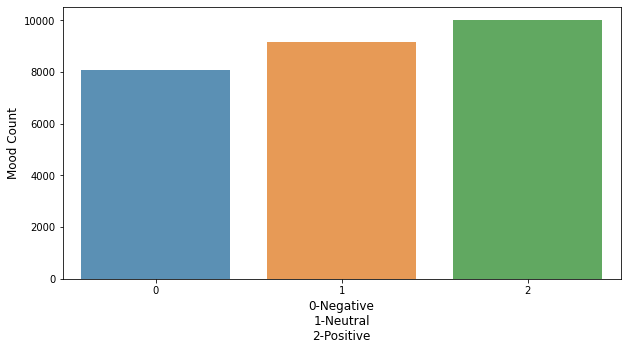

In [ ]:
mood_count3=df2['class'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(mood_count3.index, mood_count3.values, alpha=0.8)
# plt.title('Count of Moods')
plt.ylabel('Mood Count', fontsize=12)
plt.xlabel('0-Negative\n1-Neutral\n2-Positive', fontsize=12)
plt.show()

In [ ]:
df3 = df2[['crisis','class']]
list(mood_count1.index)

['hurricane', 'bombings', 'flood', 'explosion', 'tornado']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


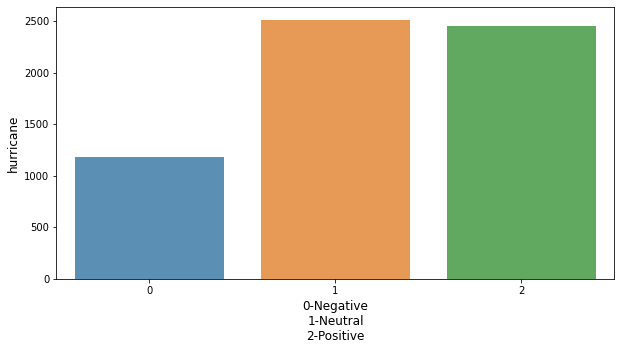

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


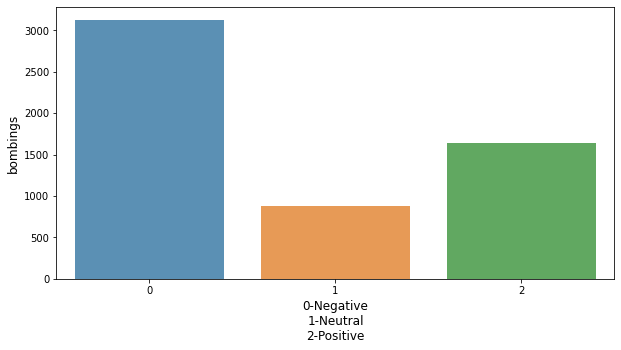

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


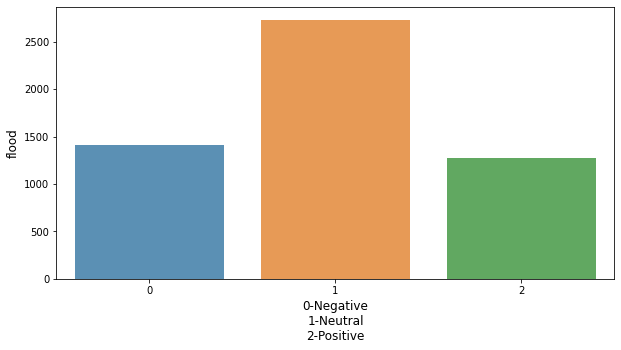

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


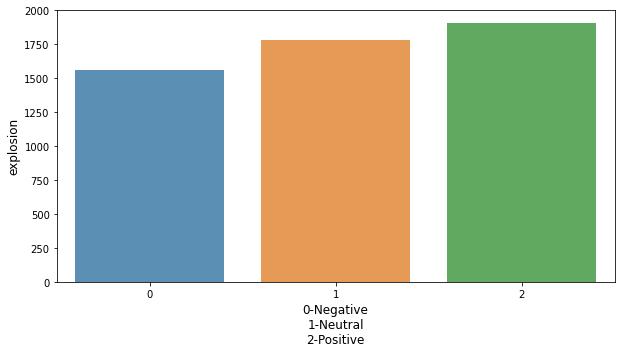

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


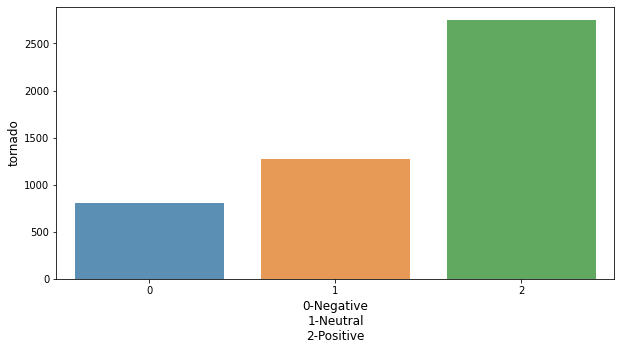

In [ ]:
for j in list(mood_count1.index):
  class0=[]
  for i in range(len(df2)):
    if df2.loc[i,'crisis'] == j:
      if df2.loc[i,'vader_pos'] > 0.1:
          class0+=[2]
      elif df2.loc[i,'vader_neg'] > 0.1:
          class0+=[0]        
      else:
          class0+=[1]
  df4 = pd.DataFrame(class0)
  df4.value_counts()
  mood_count=df4[0].value_counts()
  mood_count.index
  plt.figure(figsize=(10,5))
  sns.barplot(mood_count.index, mood_count.values, alpha=0.8)
  # plt.title('Count of Moods')
  plt.ylabel(j, fontsize=12)
  plt.xlabel('0-Negative\n1-Neutral\n2-Positive', fontsize=12)
  plt.show()


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization & Padding \n', df2['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df2['cleantext2'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 sandi soooo mad shatter door shiet hurricanesandi 
After Tokenization & Padding 
 [   9 3752 1434 2654  873  513    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
print(X.shape)


(27273, 50)


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"


In [ ]:
y = pd.get_dummies(df2['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (16363, 50) (16363, 3)
Validation Set:  (5455, 50) (5455, 3)
Test Set:  (5455, 50) (5455, 3)


In [ ]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [ ]:
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

Epoch 1/10
256/256 [==============================] - 14s 35ms/step - loss: 1.0937 - accuracy: 0.3684 - precision: 0.5000 - recall: 1.2223e-04 - val_loss: 1.0839 - val_accuracy: 0.4398 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
256/256 [==============================] - 8s 30ms/step - loss: 1.0631 - accuracy: 0.4367 - precision: 0.6683 - recall: 0.0085 - val_loss: 1.0364 - val_accuracy: 0.4790 - val_precision: 0.6243 - val_recall: 0.0603
Epoch 3/10
256/256 [==============================] - 8s 30ms/step - loss: 0.9930 - accuracy: 0.5226 - precision: 0.6971 - recall: 0.1360 - val_loss: 0.9513 - val_accuracy: 0.5540 - val_precision: 0.7153 - val_recall: 0.2321
Epoch 4/10
256/256 [==============================] - 7s 29ms/step - loss: 0.9097 - accuracy: 0.5848 - precision: 0.7291 - recall: 0.2632 - val_loss: 0.8622 - val_accuracy: 0.6191 - val_precision: 0.7331 - val_recall: 0.3806
Epoch 5/10
256/256 [==============================] - 7s 29ms/step - loss: 0.8025 - acc

In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

Accuracy  : 0.8876
Precision : 0.9038
Recall    : 0.8682
F1 Score  : 0.8856


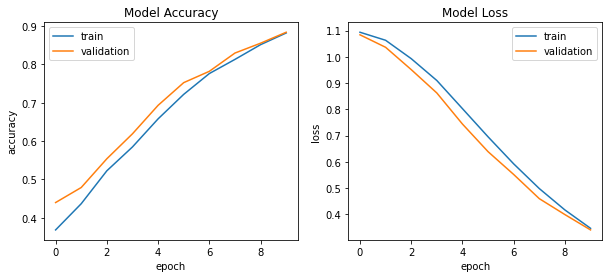

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

2    2023
1    1811
0    1621
dtype: int64
1    2097
2    1725
0    1633
dtype: int64


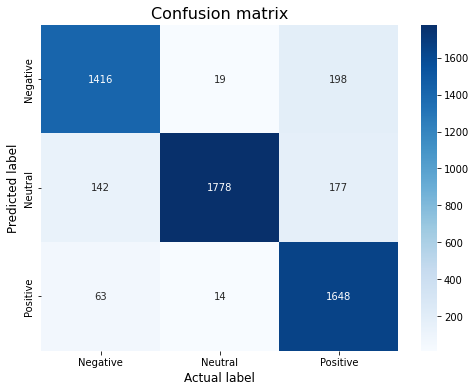

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))
    
    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)